# *Samuel Andrey Aji Prasetya*

*Dataset: https://www.kaggle.com/datasets/puneet6060/intel-image-classification* <br>
*This notebook run on kaggle*
---

## Konfigurasi API kaggle
*Digunakan saat di google colab. Saat ini notebook di jalankan menggunakan kaggle*

In [1]:
# ! chmod 600 /content/kaggle.json
# ! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d sujaykapadnis/emotion-recognition-dataset
# import zipfile
# zip_file = zipfile.ZipFile('/content/emotion-recognition-dataset.zip', 'r')
# zip_file.extractall('/content/')

## Import Package
*Import Semua package/library yang dibutuhkan*

In [2]:
import tensorflow as tf
from PIL import Image
import pandas as pd
import numpy as np
import os

from tensorflow.keras.optimizers.experimental import Adamax
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input as densePI

import matplotlib.pyplot as plt

2024-02-14 17:14:07.276161: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 17:14:07.276210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 17:14:07.277739: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Mendefinisikan direktori dataset

In [3]:
# Base directory dataset pada kaggle
BASE_DIR = '/kaggle/input/intel-image-classification/seg_train/seg_train'

## Fungsi untuk membaca file gambar pada direktori

In [4]:
# Fungsi untuk membaca file gambar dalam sebuah direktori dan subdirektorinya
def read_files(startpath):
    image_files = []  # Daftar untuk menyimpan path file gambar
    for dirname, dirnames, filenames in os.walk(startpath):
        for filename in filenames:
            # Menambahkan path lengkap dari setiap file gambar ke dalam daftar
            image_files.append(os.path.join(dirname, filename))
    return image_files  # Mengembalikan daftar path file gambar

## Membaca resolusi unik pada dataset

In [5]:
# Mengambil daftar lengkap path file gambar
full_dirs = read_files(BASE_DIR)

# Daftar untuk menyimpan ukuran gambar dan jumlah file gambar
image_sizes = []  # ukuran gambar
num_image_files = 0  # jumlah file gambar

# Mengiterasi setiap file gambar
for file in full_dirs:
    # Membuka gambar menggunakan PIL
    try:
        image = Image.open(file)
        width, height = image.size
        image_sizes.append(f'{width}x{height}')  # Menyimpan ukuran gambar
        num_image_files += 1  # Menambah jumlah file gambar
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Mendapatkan ukuran gambar unik
unique_sizes = set(image_sizes)

# Mencetak hasil
print(f'Total jumlah file gambar: {num_image_files}')
print(f'Total jumlah ukuran gambar unik: {len(unique_sizes)}')
print(f'10 ukuran gambar unik pertama: \n{list(unique_sizes)[:10]}')

Total jumlah file gambar: 14034
Total jumlah ukuran gambar unik: 31
10 ukuran gambar unik pertama: 
['150x133', '150x103', '150x115', '150x111', '150x105', '150x140', '150x147', '150x136', '150x97', '150x102']


## Mendapatkan informasi pada setiap label dataset

In [6]:
# Mengambil daftar label dari direktori utama dataset
category = os.listdir(BASE_DIR)

# Jumlah label atau class pada dataset
NUM_CLASS = len(category)

print(f"Dataset ini mempunyai: {NUM_CLASS} label\n")

total_data = 0

# Iterasi melalui setiap label
for label in category:
    # Membuat path lengkap ke direktori label
    label_dir = os.path.join(BASE_DIR, label)
    
    # Menghitung jumlah gambar untuk label tersebut
    num_images = len(os.listdir(label_dir))
    total_data += num_images
    
    print(f"Label {label}: {num_images}")
    
print(f"\nTotal Data: {total_data}")

Dataset ini mempunyai: 6 label

Label mountain: 2512
Label street: 2382
Label buildings: 2191
Label sea: 2274
Label forest: 2271
Label glacier: 2404

Total Data: 14034


## Augmentasi gambar 

In [7]:
size = (150 ,150)
batch = 32
val_split = 0.2

dataGenerator = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode = 'nearest',
    preprocessing_function = densePI,
    validation_split = val_split
)

train_data = dataGenerator.flow_from_directory(
    directory = BASE_DIR,
    target_size= size,
    class_mode='categorical',
    batch_size = batch,
    shuffle = True,
    subset="training",
    seed = 0
)

validation_data = dataGenerator.flow_from_directory(
    directory = BASE_DIR,
    target_size= size,
    class_mode='categorical',
    batch_size = batch,
    shuffle = False,
    subset="validation",
    seed = 0
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


## Mengecek bentuk data latihan dan validasi

In [8]:
x,y = train_data.next()
i,j = validation_data.next()

print(f"Train shape : {x.shape},{y.shape} \n")
print(f"Valid shape : {i.shape},{j.shape} \n")

Train shape : (32, 150, 150, 3),(32, 6) 

Valid shape : (32, 150, 150, 3),(32, 6) 



## Membuat model sequential

In [9]:
input_shape = (150, 150, 3)

# Menggunakan EfficientNetB0 sebagai model dasar, dengan menggunakan bobot pre-trained dari dataset ImageNet
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

# Melakukan iterasi pada semua layer dalam model dasar untuk membuatnya dapat dilatih (trainable)
for layer in base_model.layers:
    layer.trainable = True

# Membangun model menggunakan Sequential API dari Keras
model = tf.keras.models.Sequential([
    base_model,  # Menambahkan model dasar EfficientNetB0 ke dalam model
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),  # Menambahkan layer Conv2D dengan 32 filter
    tf.keras.layers.MaxPooling2D(2, 2),  # Menambahkan layer MaxPooling2D
    tf.keras.layers.GlobalAveragePooling2D(),  # Menambahkan layer GlobalAveragePooling2D
    tf.keras.layers.Flatten(),  # Melakukan flatten untuk mengubah hasil pooling menjadi vektor
    tf.keras.layers.Dense(512, activation='relu'),  # Menambahkan layer Dense dengan 512 unit
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),  # Menambahkan layer Dense dengan 1024 unit
    tf.keras.layers.Dropout(0.5),  # Menambahkan layer Dropout untuk mengurangi overfitting
    tf.keras.layers.Dense(NUM_CLASS, activation='softmax')  # Menambahkan layer Dense output dengan aktivasi softmax
])

# Mengompilasi model dengan pengoptimal Adamax, fungsi loss categorical_crossentropy, dan metrik akurasi
model.compile(optimizer=Adamax(learning_rate=0.0001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

16705208/16705208 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 5, 5, 1280)        4049571   
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 3, 3, 32)          368672    
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 1, 32)          0         
 D)                                                              
                                                                 
 global_average_pooling2d (  (None, 32)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 32)                0 

## Callback
*Callback untuk menghentikan proses epoch saat akurasi pada training set dan validation set mencapai >92%*

In [10]:
class AccuracyStopCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        target_accuracy = 0.92

        current_accuracy = logs.get('accuracy')
        current_val_accuracy = logs.get('val_accuracy')

        if current_accuracy is not None and current_val_accuracy is not None:
            if current_accuracy >= target_accuracy and current_val_accuracy >= target_accuracy:
                print('\nAkurasi sudah mencapai >92% pada training set dan validation set')
                self.model.stop_training = True
stop_callback = AccuracyStopCallback()

## Melatih model

In [11]:
# Hitung waktu training
start_time = time.time()

# Training
history = model.fit(
    train_data,
    epochs=25,
    validation_data=(validation_data),
    callbacks=stop_callback,
    batch_size=32,
)

# Hitung waktu training
end_time = time.time()
result_time = end_time - start_time

# Menampilkan lama proses training
print(f"Training Time : {result_time}")
print(round(result_time/60) , ' Menit')
print(round(result_time % 60), ' Detik')

Epoch 1/25


2024-02-14 17:14:46.473578: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707930891.421161     152 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


351/351 [==============================] - 139s 295ms/step - loss: 0.9658 - accuracy: 0.6394 - val_loss: 1.0953 - val_accuracy: 0.5981
Epoch 2/25
351/351 [==============================] - 104s 295ms/step - loss: 0.4647 - accuracy: 0.8352 - val_loss: 0.3780 - val_accuracy: 0.8638
Epoch 3/25
351/351 [==============================] - 102s 290ms/step - loss: 0.3707 - accuracy: 0.8693 - val_loss: 0.3051 - val_accuracy: 0.8959
Epoch 4/25
351/351 [==============================] - 100s 285ms/step - loss: 0.3243 - accuracy: 0.8868 - val_loss: 0.2856 - val_accuracy: 0.8991
Epoch 5/25
351/351 [==============================] - 100s 286ms/step - loss: 0.2906 - accuracy: 0.8986 - val_loss: 0.2961 - val_accuracy: 0.8934
Epoch 6/25
351/351 [==============================] - 101s 286ms/step - loss: 0.2580 - accuracy: 0.9081 - val_loss: 0.2545 - val_accuracy: 0.9151
Epoch 7/25
351/351 [==============================] - 105s 299ms/step - loss: 0.2521 - accuracy: 0.9121 - val_loss: 0.2389 - val_accura

## Plot terhadap akurasi dan loss model

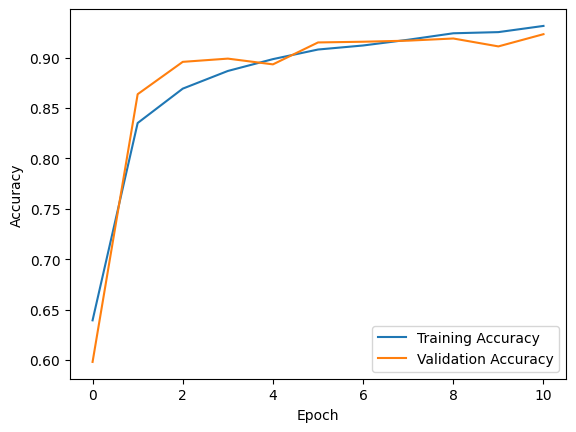

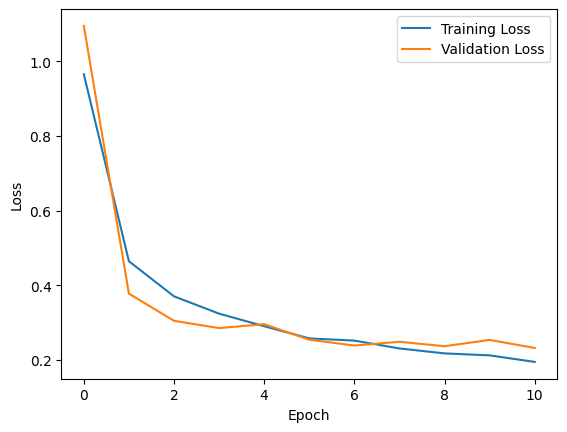

In [12]:
# Plot akurasi dan loss model
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Menyimpan model dalam bentuk TF-Lite

In [13]:
# Menyimpan model ke dalam format H5
model.save('/kaggle/working/model/model.h5')

# Konversi model ke format TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model TF-Lite
with open('/kaggle/working/model/model.tflite', 'wb') as f:
    f.write(tflite_model)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 190, Total Ops 511, % non-converted = 37.18 %
 * 190 ARITH ops

- arith.constant:  190 occurrences  (f32: 174, i32: 16)



  (f32: 9)
  (f32: 66)
  (f32: 16)
  (f32: 3)
  (f32: 65)
  (f32: 1)
  (f32: 17)
  (f32: 68)
  (i32: 16)
  (f32: 5)
  (f32: 18)
  (i32: 16)
  (f32: 1)
  (i32: 16)
  (f32: 1)
